In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [223]:
class consts:
    pi = 3.141592

class setup:
    dummy = 0
    tau_impulse = 100 #мкс для зависимости a_n от nu_n
    T_impulse = 1 #мс для зависимости a_n от nu_n
    nu_error = 1 #кГц погрешность определения частоты меньше не видно :)
    v_error = 5 #мВ погрешность определения амплитуды

In [224]:
data = mipt.read_excel('data/5.8.1-raw.xlsx', usecols=(0,1), header=(0))
data

,tp,v
0,947.0,36.42
1,937.0,36.36
2,939.0,36.34
3,939.0,36.30
4,938.0,36.30
5,938.0,36.30
6,938.0,36.29
7,937.0,36.26
8,939.0,36.26
9,938.0,36.26


## Опробование работы

In [225]:
data = mipt.read_excel('data/5.8.1-raw.xlsx', usecols=(0,1), header=(0)).dropna()
data

termo_coeff = (47000-29000)/(1168-716)

t_out = 22
t_termo = 1e3 * data['v'] / termo_coeff + t_out

t_termo_error = np.std(t_termo) / math.sqrt(t_termo.size)


t_termo.mean()
data['tp'].mean()

export = pd.concat([
    data['tp'],
    data['v'],
    t_termo.rename('tr'),  
], axis=1)


fmt = {
    'tp' : [r'$T_{p}, ^oC$', '{:.1f}', 0],
    'v' : [r'$V$, мВ', '{:.1f}', 0],
    'tr' : [r'$T_{t}, ^oC$', '{:.1f}', 0],
}

tab = mipt.table(export, fmt)
tab.to_latex('gen/tab-try.tex')

print("$$T_t = ({:.0f} \pm {:.0f}) \;\;^oC$$\n".format(t_termo.mean(), 5))
print("$$T_p = ({:.0f} \pm {:.0f}) \;\;^oC$$\n".format(data['tp'].mean(), 12))


$$T_t = (934 \pm 5) \;\;^oC$$

$$T_p = (939 \pm 12) \;\;^oC$$



In [226]:
v_error = np.std(data['v']) / math.sqrt(data['v'].size) + 0.005
#v_error / data['v'].mean() * t_termo.mean()
v_error / data['v'].mean() * t_termo.mean()



0.5244100871534852

In [227]:
t_termo_error

0.38649907606936607

## Стефан-Больцман

In [228]:
from scipy.interpolate import interp1d

data = mipt.read_excel('data/5.8.1-raw.xlsx', usecols=(2,3,4,5), header=(0)).dropna()
data

At = 1.09
At_error = 0.03
Bt = -15
Bt_error = 20

print('$$ f_1(T) = ({} \pm {}) \cdot T + ({} \pm {})$$'.format(At, At_error, Bt, Bt_error))

def br2real(x):
    return At * x + Bt

T = br2real(data['Tp'] + 273)
W = data['I'] * data['V']


$$ f_1(T) = (1.09 \pm 0.03) \cdot T + (-15 \pm 20)$$


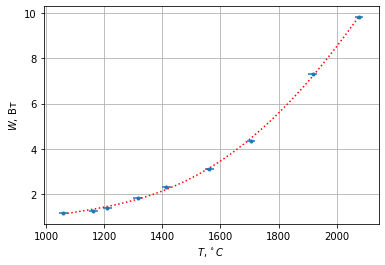

In [229]:
def interp(x, y):
    return interp1d(x, y, kind='cubic')
T = T - 273

mipt.plot(T, W, func=None, marker_size=6, exclude=[], linestyle='dashed', xerr=15)

z = np.polyfit(T, W, 4)
p = np.poly1d(z)
t = np.linspace(T.min(), T.max(), 100)
plt.plot(t, p(t), ms=10, linestyle=':', color="red")


plt.ylabel(r"$W$, Вт")
plt.xlabel(r"$T, ^\circ C$")
plt.grid(True)
# plt.legend()
plt.savefig('gen/fig-wt.pdf')

T = T + 273



In [230]:

export = pd.concat([
    data['Tp'],
    data['I'],
    data['V'],
    W.rename('W'),  
], axis=1)


fmt = {
    'Tp' : [r'$T, ^oC$', '{:.1f}', 0],
    'I' : [r'$I$, А', '{:.2f}', 0],
    'V' : [r'$V$, В', '{:.2f}', 0],
    'W' : [r'$W$, Вт', '{:.2f}', 0],
}

tab = mipt.table(export, fmt)
tab.to_latex('gen/tab-sb.tex')
tab.rename().data

,"$T, ^oC$","$I$, А","$V$, В","$W$, Вт"
0,963.0,0.563,2.115,1.190745
1,1102.0,0.590,2.389,1.409510
2,1057.0,0.571,2.194,1.252774
3,1198.0,0.638,2.881,1.838078
4,1288.0,0.686,3.402,2.333772
5,1424.0,0.752,4.166,3.132832
6,1556.0,0.837,5.218,4.367466
7,1750.0,0.992,7.357,7.298144
8,1897.0,1.098,8.950,9.827100


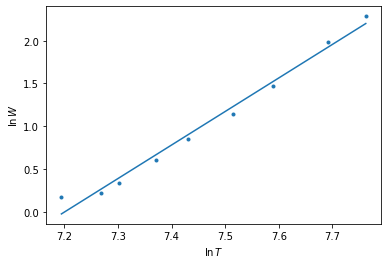

In [231]:
x, y, equ = mipt.plot(np.log(T), np.log(W), exclude=[], yerr = 0)

mnk = mipt.mnk(x, y)
mnk.to_latex('gen/tab-mnk.tex')

plt.ylabel(r"$\lnW$")
plt.xlabel(r"$\lnT$")
plt.savefig('gen/fig-linwt.pdf')

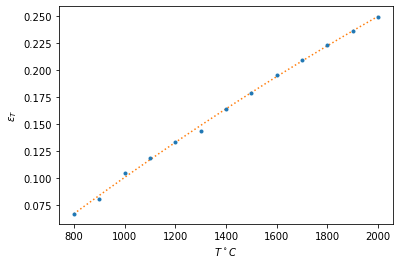

In [232]:
data_eps = mipt.read_excel('data/5.8.1-raw.xlsx', usecols=(5,6), header=(0)).dropna()

x, y, equ = mipt.plot(data_eps['Teps'], data_eps['Eps'], exclude=[], func=None)

z = np.polyfit(data_eps['Teps'], data_eps['Eps'], 2)
epsilon = np.poly1d(z)
t = np.linspace(data_eps['Teps'].min(), data_eps['Teps'].max(), 100)
plt.plot(t, epsilon(t), ms=10, linestyle=':')

plt.xlabel(r"$T ^\circ C$")
plt.ylabel(r"$\varepsilon_T$")
plt.savefig('gen/fig-epsilon.pdf')

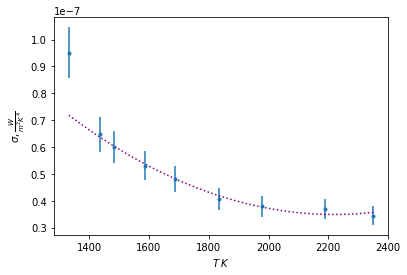

In [233]:
S = 0.36e-4
sigmas = W / (epsilon(T - 273) * T**4 * S)
sigmas

def interp(x, y):
    return interp1d(x, y, kind='cubic', bounds_error=True)

x, y, equ = mipt.plot(T, sigmas, exclude=[], func=None, linestyle='--', yerr=sigmas*0.10)


z = np.polyfit(T[1:], sigmas[1:], 2)
ff = np.poly1d(z)
t = np.linspace(T.min(), T.max(), 100)

plt.plot(t, ff(t), ms=10, linestyle=':', c ='purple')

plt.xlabel(r"$T \;K$")
plt.ylabel(r"$\sigma, \frac{W}{m^2 K^4}$")
plt.savefig('gen/fig-sigma.pdf')

In [234]:
from scipy.interpolate import interp1d
n = np.arange(1, 11, 1)

# x = data['u'][3] * 10 * np.sin(n * consts.pi * setup.tau_impulse * 1e-6/(setup.T_impulse*1e-3)) / (n * consts.pi)

def interp(x, y):
    return interp1d(x, y, kind='cubic')

y = 10 * np.sin(n * consts.pi * setup.tau_impulse * 1e-6/(setup.T_impulse*1e-3)) / (n * consts.pi)
#mipt.plot(n, data['u'], func=None, yerr=setup.v_error)
plt.bar(n, data['u'] / data['u'][0], width = 0.3)
mipt.plot(n, y, func=interp, marker_size=0, linestyle='dashed')

plt.xlabel(r"$\nu_n$, кГц")
plt.ylabel(r"$a_n$")
plt.grid(True)
# plt.legend()
plt.savefig('gen/fig-a9.pdf')




KeyError: 'u'

#### A11 Постройте график зависимости Δ𝜈(1/𝜏). Проведите наилучшую прямую и по её наклону убедитесь в справедливости соотношения неопределённостей для длительности импульса и ширины спектра. Оцените погрешность данного опыта

In [ ]:
dv = data['dv']
tau = data['t']

x, y, equ = mipt.plot(1/tau, dv, yerr = setup.nu_error)
mnk = mipt.mnk(x,y)
mnk.to_latex('gen/tab-a11-mnk.tex')

plt.xlabel(r"$1/\tau$, 1/мс")
plt.ylabel(r"$\nu$, кГц")
plt.grid(True)
# plt.legend()
plt.savefig('gen/fig-a11.pdf')


fmt = {
    'dv' : [r'$\Delta\nu$, кГц', '{:.1f}', 0],
    't' :  [r'$\tau$, мс', '{:.0f}', 0],
    '1/tau' :  [r'$\frac{1}{\tau}$, 1/мс', '{:.4f}', 0],
}

dat = pd.concat([dv, tau, (1/tau).rename('1/tau')],axis=1)
tab = mipt.table(dat, fmt)
tab.to_latex('gen/tab-a11.tex')


#### В21 Постройте график зависимости 𝑎бок/𝑎осн от 𝑚. Проведите наилучшую прямую и сравните результат теоретическим. Оцените погрешность данного опыта.


,$\overline{x}$,$\sigma_x^2$,$\overline{y}$,$\sigma_y^2$,$r_{xy}$,$a\cdot10^3$,$\Delta a \cdot10^3$,$b$,$\Delta b$
0,55.0,825.0,0.216197,0.013571,3.342053,0.004051,0.00007,-0.006607,0.00433


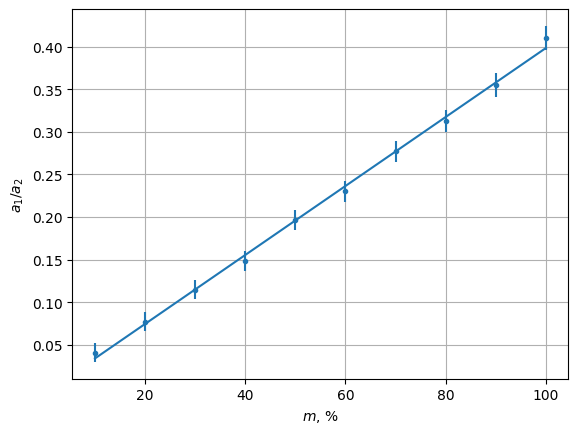

In [14]:
dat = dat = pd.concat([
    data['m'], 
    data['ao'],  
    data['ab'],
    (data['ab']/data['ao']).rename('bo'),
],axis=1)

x, y, equ = mipt.plot(dat['m'], dat['bo'], yerr = 1.5 * dat['bo'] * setup.v_error / dat['ab'])

mnk_fmt = {
    '<x>':    ['$\overline{x}$', '{:.2e}'],
    'sx':     ['$\sigma_x^2$',   '{:.2e}'],
    '<y>':    ['$\overline{y}$', '{:.2e}'],
    'sy':     ['$\sigma_y^2$',   '{:.2e}'],
    'rxy':    ['$r_{xy}$',       '{:.2e}'],
    'a':      ['$a\cdot10^3$', '{:.2f}', 3],
    'da':     ['$\Delta a \cdot10^3$', '{:.2f}', 3],
    'b':      ['$b$',            '{:.2e}'],
    'db':     ['$\Delta b$',     '{:.2e}'],
}


mnk = mipt.mnk(x,y,fmt=mnk_fmt)
mnk.to_latex('gen/tab-v21-mnk.tex')

plt.xlabel(r"$m$, %")
plt.ylabel(r"$a_1/a_2$")
plt.grid(True)
# plt.legend()
plt.savefig('gen/fig-v21.pdf')

fmt = {
    'm'  : [r'$m$, \%', '{:.0f}', 0],
    'ao' : [r'$a_{\text{осн}}$, мВ', '{:.1f}', 0],
    'ab' : [r'$a_{\text{бок}}$, мВ', '{:.1f}', 0],
    'bo' : [r'$\frac{a_{\text{бок}}}{a_{\text{осн}}}$', '{:.4f}', 0],
}

tab = mipt.table(dat, fmt)
tab.to_latex('gen/tab-v21.tex')
mnk.rename().data

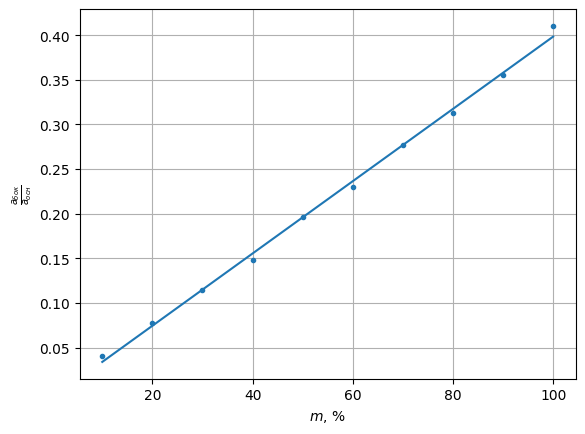

In [15]:
x, y, equ = mipt.plot(dat['m'], dat['bo'])
mnk = mipt.mnk(x,y)
mnk.to_latex('gen/tab-v21-mnk.tex')

plt.xlabel(r"$m$, %")
plt.ylabel(r"$\frac{a_{бок}}{a_{осн}}$")
plt.grid(True)
# plt.legend()
plt.savefig('gen/fig-v21.pdf')


fmt = {
    'm'  : [r'$m$, %', '{:.0f}', 0],
    'ao' : [r'$\tau$, мВ', '{:.1f}', 0],
    'ab' : [r'$\frac{1}{\tau}$, мВ', '{:.1f}', 0],
    'bo' : [r'$\frac{a_{\text{бок}}}{a_{\text{осн}}}$', '{:.4f}', 0],
}

tab = mipt.table(dat, fmt)
tab.to_latex('gen/tab-v21.tex')